In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
# Disable pysindy to generate a deprecation warning
warnings.filterwarnings("ignore", message="pkg_resources is deprecated")
import pysindy as ps
import scipy as sp
import os
from sklearn.metrics import mean_squared_error
import pickle
from matplotlib import gridspec
import pandas as pd
from scipy import stats
import matplotlib.legend_handler
from utils import Dataset

/home/rbelouso/miniforge3/envs/hemo/lib/python3.12/site-packages/pysindy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


In [2]:
params = { 'figure.figsize': (15.,5.),
          'axes.labelsize': 22,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'legend.fontsize': 16,
          # 'font.sans-serif': 'Arial', # RB: This does not work on unix wihtout fonts installed
          'lines.linewidth': 2}
plt.rcParams.update(params)

In [3]:
colors = ["#377eb8", "#ff7f00", "#4daf4a"]

## Read the data of AVM patients

In [4]:
# folderpath = r"../data/clinical_data/"
# filepaths = [os.path.join(folderpath, name) for name in os.listdir(folderpath)]
# patients = []
# for i in range(len(filepaths)):
#     patients.append(str.split(os.path.basename(filepaths[i]), '-')[0])
# patients = np.unique(patients)

In [5]:
# patients_AA = ['G2', 'K1', 'K3', 'R1', 'S2']
# patients_AVM = ['G1', 'K2', 'L1', 'S1', 'S3']

In [6]:
dataset = Dataset('data/AVM')
P = dataset.all_pressures()
V = dataset.all_velocities()
# for i in range(len(filepaths)):
#     if (str.split(os.path.basename(filepaths[i]), '-')[1] == 'AVM'):
#         P[i] = np.loadtxt(filepaths[i]+"/data_p.txt")
#         V[i] = np.loadtxt(filepaths[i]+"/data_v.txt")

In [7]:
# for i in P.keys():
#     P[i] = P[i]*100 #pressure in mmHg

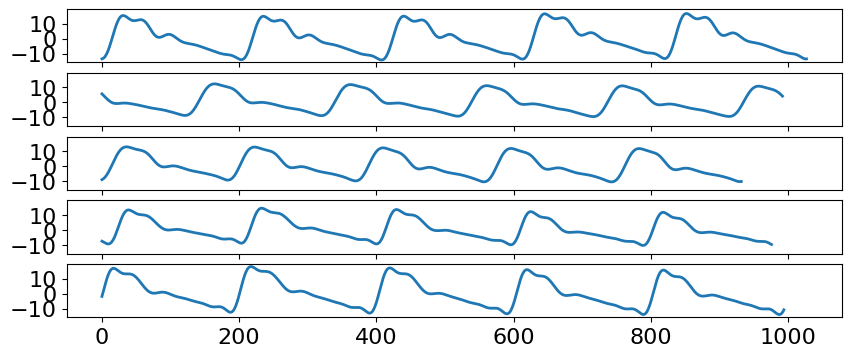

In [8]:
fig, axs = plt.subplots(ncols=1, nrows=5, sharex=True, sharey=True, figsize=(10,4))
axs = axs.ravel()
for idx, i in enumerate(list(P.keys())[:5]):
    axs[idx].plot(P[i])

In [9]:
def Heun(f, y0, t):  # Heun integrator
    y = np.zeros((len(t),len(y0)))
    y[0] = y0
    for i in range(len(t)-1):
        dt = t[i+1] - t[i]
        y_tilde = y[i] + dt*f(y[i],t[i],v[i]) # Euler formulation
        y[i+1] = y[i] + 0.5*dt*(f(y[i],t[i],v[i])+f(y_tilde,t[i]+dt,v[i+1]))
    return y

In [10]:
dt = 1/200

## state variables

In [11]:
# p and pdot are the state variables for a second order ODE model discovery
states = {}
for i in P.keys():
    states[i] = np.vstack([P[i], np.gradient(P[i], dt), V[i]])

## construct the candidate library

In [12]:
lib_V = ps.PolynomialLibrary(degree=1, include_bias=False, include_interaction=False)
lib_P = ps.PolynomialLibrary(degree=3, include_bias=False, include_interaction=True)
lib = ps.GeneralizedLibrary([lib_P, lib_V], inputs_per_library=np.array([[0,1],[2,2]]))

In [13]:
feature_names = ["p", "p'", "v"]

## calculate the numerical derivatives

In [14]:
#for the left hand side of the ODEs, we need pdot and pdotdot
derivatives = {}
for i in P.keys():
    derivatives[i] = np.zeros_like(states[i])
    for j in range(3):
        derivatives[i][j] = np.gradient(states[i][j,:], dt)

## model discovery

In [15]:
scikit_optimizer = ps.STLSQ(threshold=.1, alpha=0., fit_intercept=False)
coeff = {}
for i in P.keys():
    model = ps.SINDy(optimizer=scikit_optimizer, feature_library=lib, 
                        feature_names=feature_names).fit(states[i].T, t=dt, x_dot=derivatives[i][:2].T, quiet=True)
    coeff[i] = model.coefficients()
    model.print(lhs=['dotp', 'ddotp', 'v'])

dotp = 1.000 p'
ddotp = -379.697 p + -20.546 p' + -0.810 p^2 + -0.987 p p' + -0.403 p^3 + 62152.506 v
dotp = 1.000 p'
ddotp = -114.986 p + 0.581 p' + -0.352 p^2 + -1.695 p p' + 2622.063 v
dotp = 1.000 p'
ddotp = -67.880 p + 4.860 p' + 0.372 p^2 + -1.685 p p' + -0.116 p^3 + -3700.513 v
dotp = 1.000 p'
ddotp = -144.190 p + -2.531 p' + 3.615 p^2 + -2.253 p p' + -1.319 p^3 + 16038.147 v
dotp = 1.000 p'
ddotp = -323.520 p + -10.211 p' + 2.033 p^2 + -1.332 p p' + -0.595 p^3 + 21188.613 v
dotp = 1.000 p'
ddotp = -206.250 p + -17.340 p' + 0.756 p^2 + -0.765 p p' + -0.212 p^3 + 55019.354 v
dotp = 1.000 p'
ddotp = -294.760 p + -5.637 p' + 3.310 p^2 + -3.009 p p' + -0.249 p^3 + 12984.862 v
dotp = 1.000 p'
ddotp = -432.290 p + -25.430 p' + -2.424 p^2 + -0.507 p p' + 65891.311 v
dotp = 1.000 p'
ddotp = -226.383 p + -18.735 p' + 1.212 p^2 + -0.883 p p' + -0.479 p^3 + 24823.671 v
dotp = 1.000 p'
ddotp = -74.224 p + -6.841 p' + 4.167 p^2 + -2.831 p p' + -1.406 p^3 + 0.439 p^2 p' + 2851.819 v
dotp = 1.

## simulations of predicted models

In [16]:
def predicted_pressure(u,t,v):
    return np.array([u[1],
                     coef[0]*u[0] + coef[1]*u[1] + coef[2]*u[0]**2 + coef[3]*u[0]*u[1] + coef[4]*u[1]**2 
                     + coef[5]*u[0]**3 + coef[6]*(u[0]**2)*u[1] + coef[7]*u[0]*(u[1]**2) + coef[8]*u[1]**3 + coef[9]*v])

In [22]:
predicted_p = {}
for i in P.keys():
    print(i)
    v = V[i] #include the emprical velocity in the simulations of predicted models
    coef = coeff[i][1]
    time = np.array([j*dt for j in range(len(P[i]))])
    predicted_p[i] = Heun(predicted_pressure, [P[i][0], 0.], time) #initial value is chosen from the empirical pressure
predicted_p

G1.BEFORE
G1.DURING
G1.AFTER
K2.BEFORE
K2.DURING
K2.AFTER
L1.BEFORE
L1.DURING
L1.AFTER
S1.BEFORE
S1.DURING
S1.AFTER
S3.BEFORE
S3.DURING
S3.AFTER


/tmp/ipykernel_36251/553368757.py:4: RuntimeWarning: overflow encountered in scalar power
  + coef[5]*u[0]**3 + coef[6]*(u[0]**2)*u[1] + coef[7]*u[0]*(u[1]**2) + coef[8]*u[1]**3 + coef[9]*v])
/tmp/ipykernel_36251/553368757.py:4: RuntimeWarning: invalid value encountered in scalar multiply
  + coef[5]*u[0]**3 + coef[6]*(u[0]**2)*u[1] + coef[7]*u[0]*(u[1]**2) + coef[8]*u[1]**3 + coef[9]*v])


{'G1.BEFORE': array([[-13.3918782 ,   0.        ],
        [-13.34606622,  19.67505564],
        [-13.19559125,  41.79002984],
        ...,
        [-11.20725712,   2.29618797],
        [-11.18244813,   8.652561  ],
        [-11.12094007,  17.04795611]]),
 'G1.DURING': array([[ 5.75167991,  0.        ],
        [ 5.74309416, -3.38199764],
        [ 5.7178661 , -6.65325696],
        ...,
        [        nan,         nan],
        [        nan,         nan],
        [        nan,         nan]]),
 'G1.AFTER': array([[-8.95931263,  0.        ],
        [-8.94947454,  4.04075115],
        [-8.91889223,  8.29782456],
        ...,
        [        nan,         nan],
        [        nan,         nan],
        [        nan,         nan]]),
 'K2.BEFORE': array([[  -7.49421486,    0.        ],
        [  -7.49140365,    1.13181727],
        [  -7.48291024,    2.3132016 ],
        ...,
        [ -20.22704646, -140.34249255],
        [ -20.83363257,  -95.07328339],
        [ -21.17590028,  -33.46

In [18]:
non_problematic_keys = [3, 8, 9, 12, 13, 16, 17, 18, 20, 23, 26, 29]


## comparison between the simulated pressure and empirical pressure

KeyError: 3

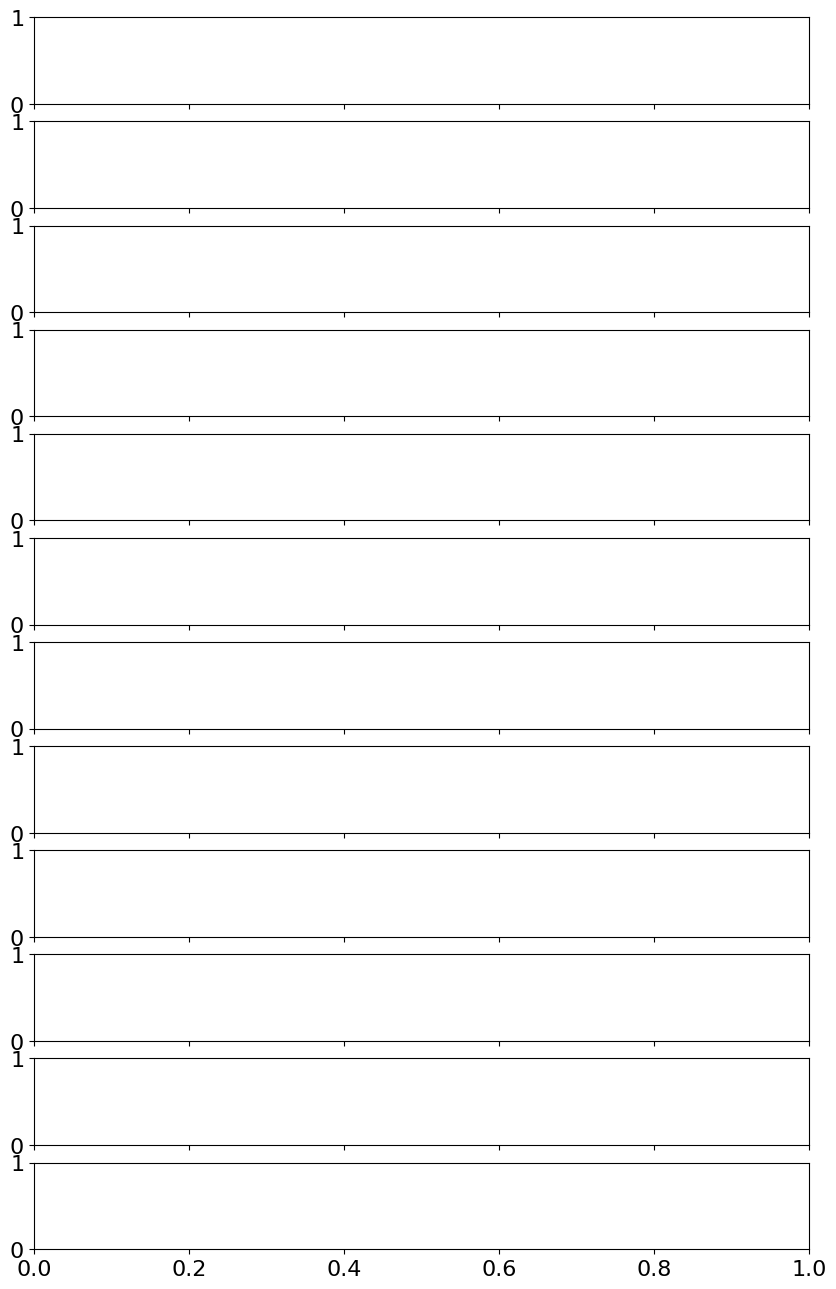

In [19]:
fig, axs = plt.subplots(nrows=12, ncols=1, figsize=(10,16), sharex=True)
axs = axs.ravel()
for idx, i in enumerate(non_problematic_keys):
    axs[idx].plot(np.array([k*dt for k in range(len(P[i]))]), P[i], label="Experimental pressure")
    axs[idx].plot(np.array([k*dt for k in range(len(P[i]))]), predicted_p[i][:,0], label="Simulated pressure")
    
axs[11].set_xlabel("Time (s)")
axs[5].set_ylabel("Pressure (mmHg)")
axs[0].legend(frameon=False, fontsize=12)
fig.tight_layout()